In [6]:
from pylab import*
%matplotlib inline

import skimage
from scipy import ndimage
from skimage import *
from skimage.exposure import rescale_intensity

import numpy as np
import numpy.matlib
import time
import scipy.io



### Neke funkcije koje se koriste u celom domacem zadatku

In [1]:
def cnotch(filt_type, notch, M, N, C, r, n=1):
    """
    lpfilter: funkcija koja na osnovu ulaznih parametara kreira zadati tip niskopropusnog filtra
    
    Ulazni paramterni funkcije:
        - filt_type: tip filtra, moze biti 'gaussian', 'btw' (butterworth), 'ideal'
        - notch: 'pass' ako je propusnik ili 'reject' ako je nepropusnik
        - M, N: dimenzije slike
        - C: niz koordinata oko kojeg formiraju filtri
        - r: 'gaussian', 'btw'- standardna devijacija
             'ideal' - radijus filtra
        - n: 'btw' - red filtra
    
    Izlaz funkcije:
        - filter_mask: maska kreiranog filtra
    """
    
    N_filters = len(C);
    
    # inicijalizacija maske
    filter_mask = zeros([M,N]);
    
    # pravimo pass filtar, pa u slucaju da je reject
    # oduzecemo od matrice jedinica

    # centriranje x i y koordinata
    if (M%2==0):
        y = np.arange(0,M) - M/2 + 0.5; 
    else:
        y = np.arange(0,M) - (M-1)/2;
    if (N%2 == 0):
        x = np.arange(0,N) - N/2 + 0.5;
    else:
        x = np.arange(0,N) - (N-1)/2; 
    
    X,Y = meshgrid(x,y)
    
    for i in range(0,N_filters):
        C_current = C[i] # njegova x i y koord

        if (M%2==0):
            y0 = y - C_current[0] + M/2 - 0.5;
        else:
            y0 = y - C_current[0] + (M-1)/2;
        if (N%2 == 0):
            x0 = x - C_current[1] + N/2 - 0.5; 
        else:
            x0 = x - C_current[1] + (N-1)/2;
        
        # centralno-simetricne komponente su obavezne kako
        # bi izlaz bio realan 
        x0c = -x0 + 2*x;
        y0c = -y0 + 2*y;
            
        X0,Y0 = meshgrid(x0,y0)    
        D0 = np.sqrt(np.square(X0) + np.square(Y0)); 
        
        X0c,Y0c = meshgrid(x0c,y0c)    
        D0c = np.sqrt(np.square(X0c) + np.square(Y0c)); 

        if filt_type == 'gaussian':
            filter_mask = filter_mask + \
                          exp(-np.square(D0)/(2*np.square(r))) + \
                          exp(-np.square(D0c)/(2*np.square(r)))
        elif filt_type == 'btw':
            filter_mask = filter_mask + \
                          1/(1+(D0/r)**(2*n)) + \
                          1/(1+(D0c/r)**(2*n))
        elif filt_type == 'ideal':
            filter_mask[(D0<=r)|(D0c<=r)] = 1
        else:
            print('Greska! Nije podrzan tip filtra: ', filt_type)
            return
    
    if notch == 'pass':
        return filter_mask
    elif notch == 'reject':
        return 1 - filter_mask
    else:
        return 
  

In [2]:
def lpfilter(filt_type, M, N, sigma, n=1): # gaus, bater, idealna,  - type
    
    """
    lpfilter: funkcija koja na osnovu ulaznih parametara kreira zadati tip niskopropusnog filtra
    
    Ulazni paramterni funkcije:
        - filt_type: tip filtra, moze biti 'gaussian', 'btw' (butterworth), 'ideal', 'ellipse'
        - M, N: dimenzije slike
        - sigma: 'gaussian', 'btw' - standardna devijacija
                 'ideal' - maksimalna frekvencija spektra koja se propusta
                 'ellipse' - maksimalna frekvencija po horizontalnoj osi koja se propusta
        - n: 'btw' - red filtra
             'ellipse' - maksimalna frekvencija po vertikalnoj osi koja se propusta
    
    Izlaz funkcije:
        - filter_mask: maska kreiranog filtra
    """
    
    if (M%2==0):
        y = np.arange(0,M) - M/2 + 0.5;
    else:
        y = np.arange(0,M) - (M-1)/2;
    if (N%2 == 0):
        x = np.arange(0,N) - N/2 + 0.5; 
    else:
        x = np.arange(0,N) - (N-1)/2;
    
    X,Y = meshgrid(x,y)
    
    # rastojanje od centra 
    D = np.sqrt(np.square(X) + np.square(Y)); 
    # rastojanje po formuli za elipsu
    D_el =  np.sqrt(np.square(X)/sigma**2 + np.square(Y)/n**2) ;
    
    if filt_type == 'gaussian':
        filter_mask = exp(-np.square(D)/(2*np.square(sigma))) 
    elif filt_type == 'btw':
        filter_mask = 1/(1+(D/sigma)**(2*n))
    elif filt_type == 'ideal':
        filter_mask = ones([M,N])
        filter_mask[D>sigma] = 0
    elif filt_type == 'ellipse':
        filter_mask = ones([M,N])
        filter_mask[D_el>1] = 0
    else:
        print('Greska! Nije podrzan tip filtra: ', filt_type)
        return
    
    return filter_mask


In [3]:
def to_img(spectar):
    """
    to_img: funkcija koja vraca sliku na osnovu spekra i vrsi popravku intenzitera
    
    Ulazni paramterni funkcije:
        - spectar: spektar slike
    
    Izlaz funkcije:
        - img_rescaled: izlazna slika
    """
    
    img = real(ifft2(ifftshift(spectar)))
    img[img<0] = 0
    img[img>1] = 1
    img = rescale_intensity(img)
    
    return img

## Prvi zadatak

### Potrebno je popraviti kvalitet slike girl_ht.tif. Kad plotujemo spektar vidimo da bi prvi korak mogao biti niskopropusni filtar. On mora biti jako uzak da ne bi uhvatio 'bele tackice' oko centra, koje predstavljaju poremecaj i nalaze se u celom spektru. Zbog toga je slika filtrirana samo ovim uskim filtrom, iako uniformna, mutna.
### Sledece resenje je prosiriti niskopropusni filtar, medjutim, tada treba odstraniti bele tackice koje upadaju u njegov opseg. Jednostavno ih je locirati i odstraniti uz notch filtar. Rezultujuca slika je dosta bolja od prethodne i zadovoljavajuca. 
### Napomena: popravka slike je vrsena u sklopu funkcije to_img, tako da je i taj korak ka popravci kvaliteta slike nacinjen.

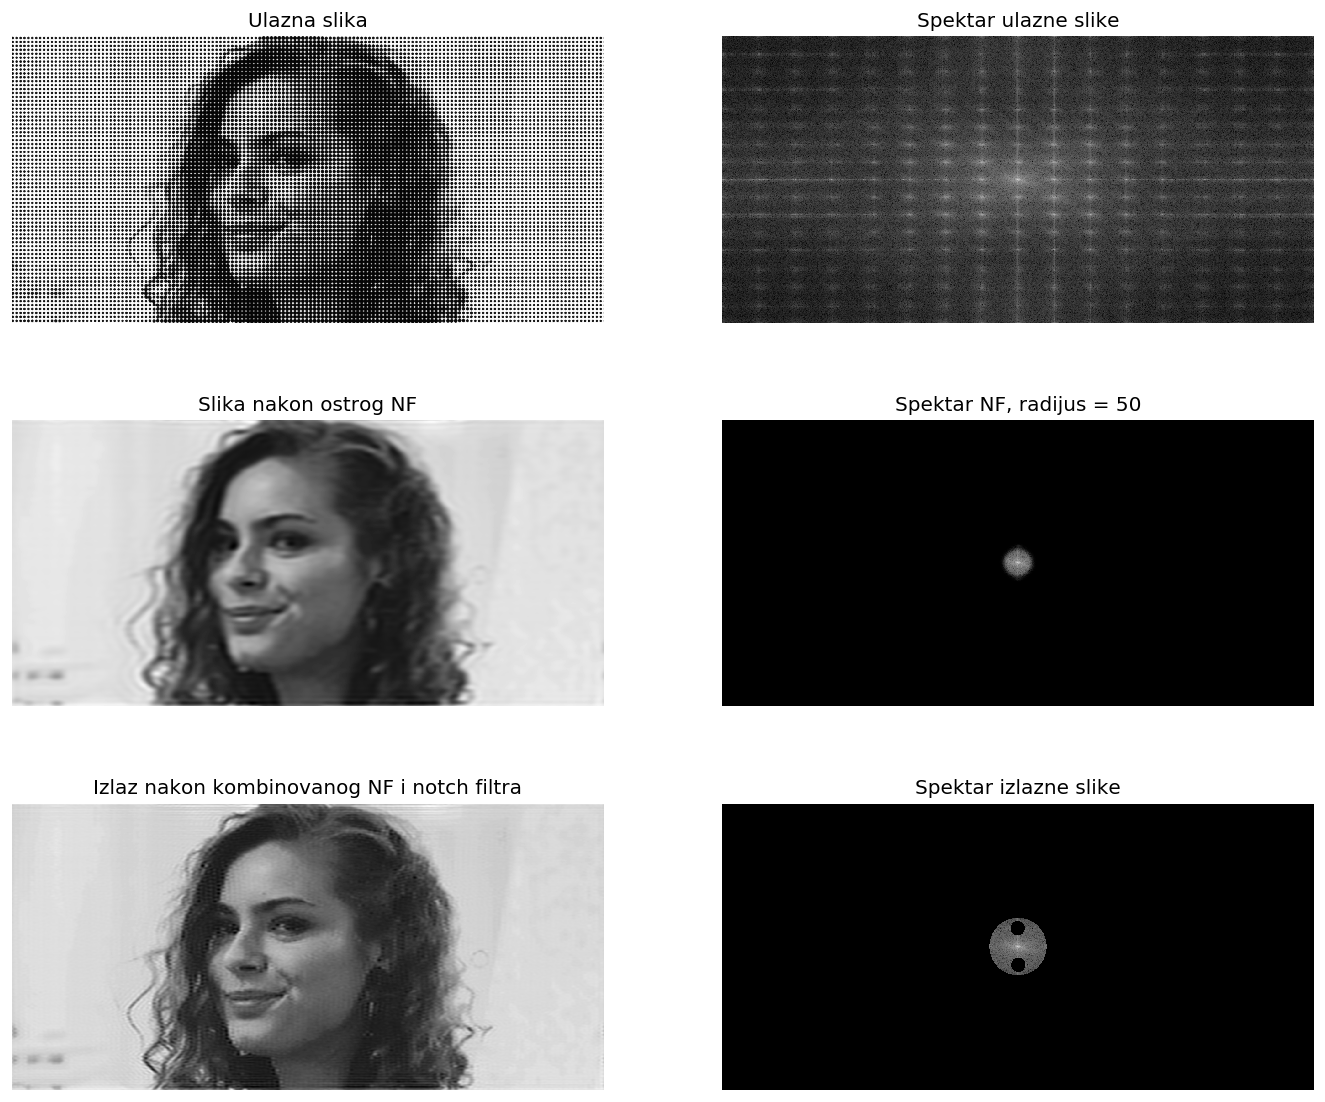

In [378]:
%matplotlib inline

f1 = img_as_float(imread('girl_ht.tif'))
[M1,N1] = shape(f1)
F1 = fftshift(fft2(f1))

points_noise = [[523.0, 1238.0]]
H1 = cnotch('ideal','reject',M,N,points_noise,30)
Hlp1 = lpfilter('ideal', M1, N1, 120)
Hlp2 = lpfilter('btw', M1, N1, 50,10)
G1_nf = F1*Hlp2
G1_notch = F1*H1
G1 = F1*H1*Hlp1

g1_nf = to_img(G1_nf)
g1_notch = to_img(G1_notch)
g1 = to_img(G1)

fig,axes = plt.subplots(nrows=3, ncols=2, figsize=(14,12), dpi=120) 
ax = axes.ravel()

ax[0].imshow(f1,cmap='gray'); ax[0].set_axis_off(); ax[0].set_title('Ulazna slika')
ax[1].imshow(log(1+abs(F1)),cmap='gray'); ax[1].set_axis_off(); ax[1].set_title('Spektar ulazne slike')
ax[2].imshow(g1_nf,cmap='gray'); ax[2].set_axis_off(); ax[2].set_title('Slika nakon ostrog NF')
ax[3].imshow(log(1+abs(G1_nf)),cmap='gray'); ax[3].set_axis_off(); ax[3].set_title('Spektar NF, radijus = 50')
ax[4].imshow(g1,cmap='gray',vmin=0,vmax=1); ax[4].set_axis_off(); ax[4].set_title('Izlaz nakon kombinovanog NF i notch filtra')
ax[5].imshow(log(1+abs(G1)),cmap='gray'); ax[5].set_axis_off(); ax[5].set_title('Spektar izlazne slike')


plt.show()



## Drugi domaci zadatak 

### Potrebno je proceniti varijansu šuma slike lena_noise.tif. Ako smatramo da je vecina slike uniformna, bez suma ti uniformni delovi imali bi varijasnu 0, medjutim, zbog uticaja suma, varijansa tih delova ce biti jednaka varijansi suma. Variracemo lokalno susedstvo na osnovu koga racunamo varijanse piksela slike, zatim cemo plotovati histograme.

In [4]:
def calculateVar(r,img):
    """
    calculateVar - funkcija koja izracunava varijansu u svakom pikselu zadate slike 
    Ulazni parametri funkcije:
        - r:   radijus lokalnog susedstva
        - img: slika cijih piksela varijansu je potrebno izracunati 
    Izlaz funkcije:
        - gvar: matrica dimenzija kao ulazna slika, na cijim se poljima
                nalaze varijanse odgovarajucih piksela 
    """
    dim = 2*r+1;
    h_avg = ones([dim,dim])/(dim**2)
    g_avg = ndimage.correlate(img,h_avg);
    gsqr_avg = ndimage.correlate(img**2,h_avg)
    gvar = gsqr_avg - g_avg**2;
   
    return gvar

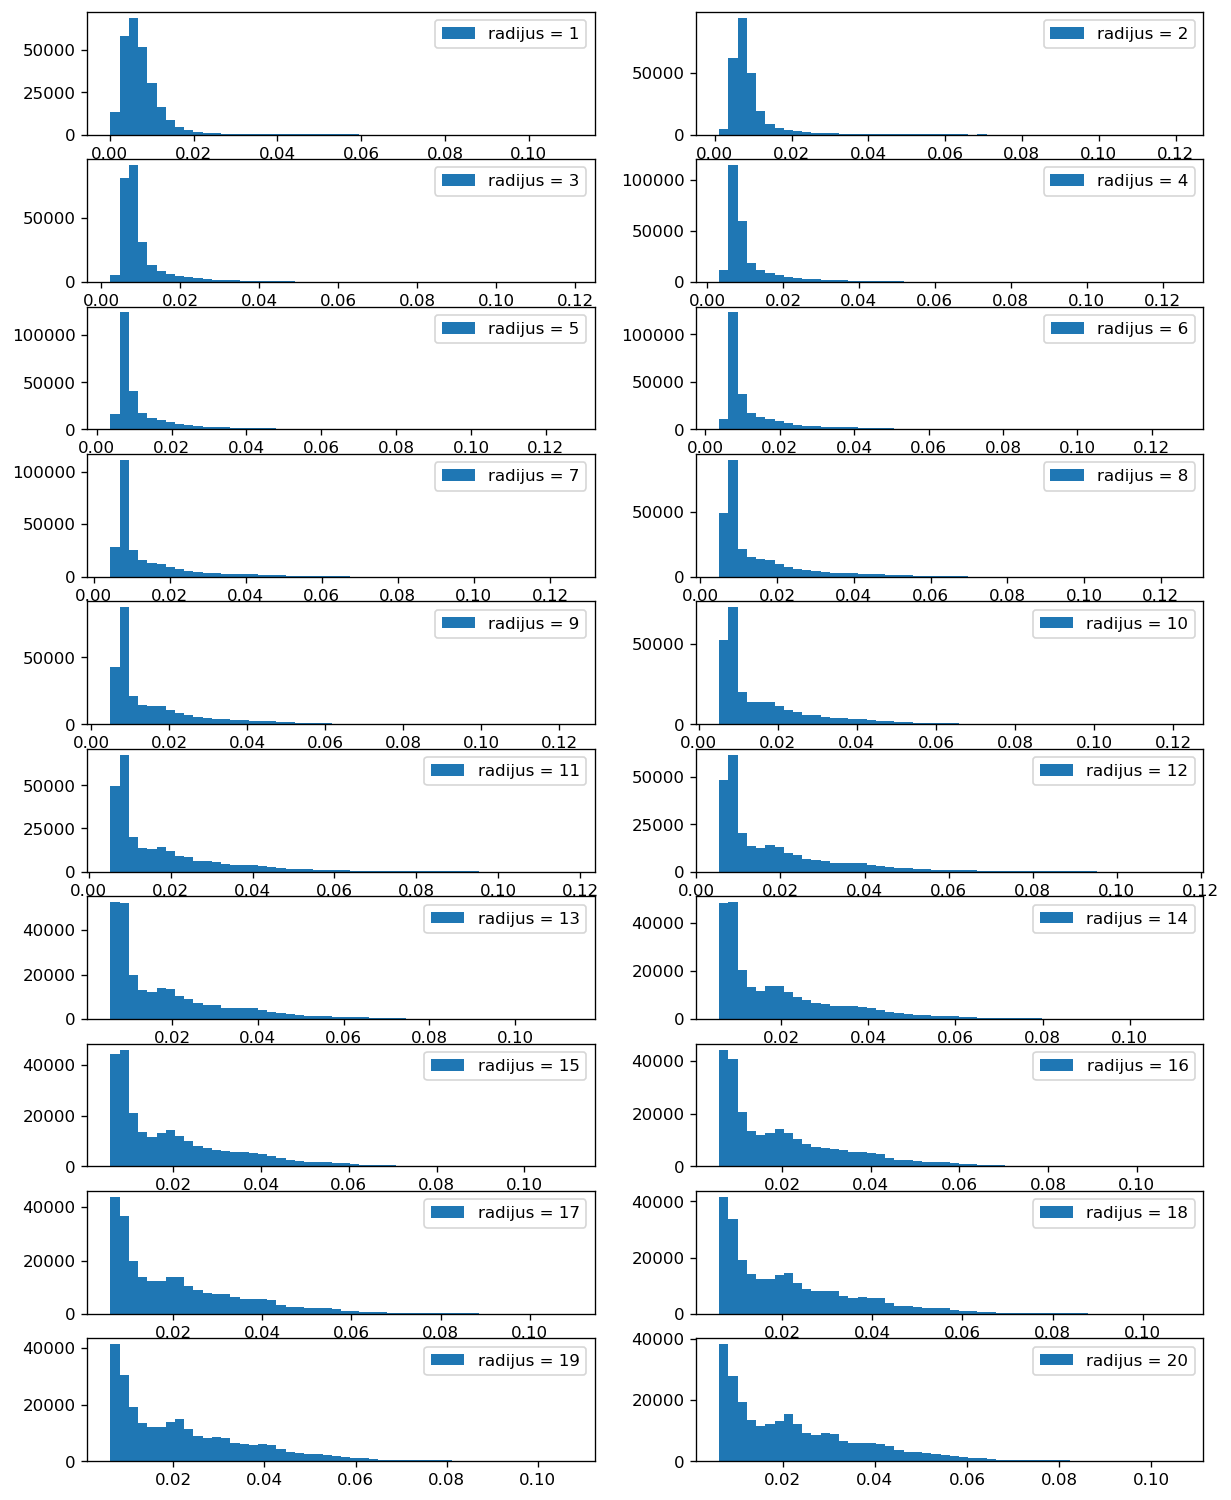

In [44]:
# ucitavanje slike
f2 = img_as_float(imread('lena_noise.tif'))

# promenljive za cuvanje podataka iz histograma
n = np.zeros([20,50])       # vrednosti stubica
bins = np.zeros([20,51])    # koordinate stubica

fig,axes = plt.subplots(nrows=10, ncols=2, figsize=(12,16), dpi=120) 
ax = axes.ravel()

for i in range(1,21):
    gvar = calculateVar(i,f2)        
    [n[i-1],bins[i-1],_] = ax[i-1].hist(gvar.flatten(), density = False, bins = 50)
    ax[i-1].legend(['radijus = ' + str(i)])

plt.show()

# izdvajanje najucestalije varijanse iz podataka dobijenih iz histograma
nvar_max_array = np.max(n,axis=1)
indexes = np.zeros([20,1])
nvar_array = np.zeros([20,1])
for i in range(0,20):
    indexes[i,:] = np.where(n[i,:] == nvar_max_array[i])
    nvar_array[i,:] =(bins[i,int(indexes[i])] + bins[i,int(indexes[i]+1)])/2;

    

### Primecujemo na histogramima pik na odredjenoj varijansi, za svaki smo i izracunali koliko iznosi (oko 0.007 za vecinu radijusa). Sto se tice izgleda histograma, oni prilicno variraju. Za premale radijuse lokalnog susedstva broj piksela za koje racunamo varijansu je nedovoljan da bi varijansa bila validna, a za vece vrednosti radijusa u lokalno susedstvo upada mnogo vise razlicitih piksela, ivica, promena intenziteta, pa je ocekivano da imamo vise piksela sa vecom varijansom. 
### Uzecemo kao konacnu velicinu radijusa 7, jasno je izrazen pik, a broj piskela u lokalnom susedstvu je dovoljan da procena bude verodostojna.

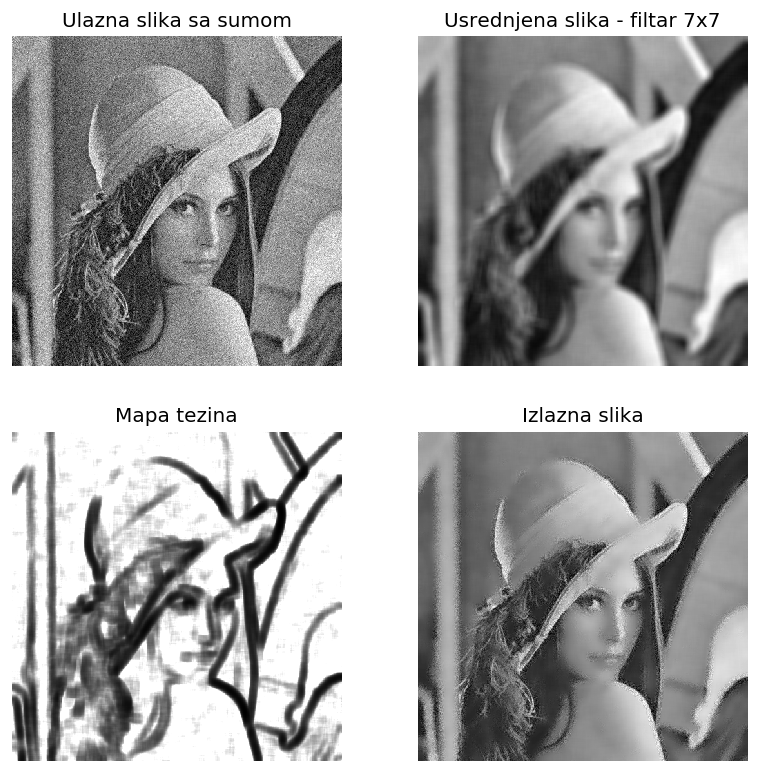

In [98]:
# rucno cemo izracunati ovde varijansu bez poziva funkcije jer 
# zelimo da plotujemo i medjurezultate
radius = 7
h_avg = ones([dim,dim])/(dim**2)
g_avg = ndimage.correlate(f2,h_avg);
gsqr_avg = ndimage.correlate(f2**2,h_avg)
gvar = gsqr_avg - g_avg**2;
nvar = nvar_array[radius-1]
w = nvar/gvar ;
w[w>1] = 1

f2_est = f2 + w*(g_avg-f2); 

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(8,8), dpi=120)
ax = axes.ravel()

ax[0].imshow(f2,cmap='gray');  ax[0].set_axis_off(); ax[0].set_title('Ulazna slika sa sumom')
ax[1].imshow(g_avg,cmap='gray');  ax[1].set_axis_off(); ax[1].set_title('Usrednjena slika - filtar ' + str(radius) + 'x' + str(radius))
ax[2].imshow(w,cmap='gray');  ax[2].set_axis_off(); ax[2].set_title('Mapa tezina')
ax[3].imshow(f2_est,cmap='gray'); ax[3].set_axis_off(); ax[3].set_title('Izlazna slika')


plt.show()



## Treci domaci zadatak 

### Potrebno je pronaci varijansu degradacione funkcije koja je pogodila sliku, zatim izvrsiti restauraciju u vidu inverznog filtriranja u spektru (ako je slika pogodjena sumom, znaci da je u spektru izvrseno mnozenje, pa posto zelimo sad obrnuti postupak, podelicemo spektar dobijene slike sa spektrom estimirane degradacione funkcije). Nakon ovoga javlja se pogorsanje spektra na visim ucestanostima, pa je potrebno primeniti niskopropusni filter, u ovom slucaju odgovarajuci je onaj u obliku elipse (jer je spektar slike takvog oblika, pa na taj nacin cuvamo najvecu kolicinu informacija na niskim ucestanostima, samim tim slika ce biti jasnija).

In [4]:
def to_colored_img(spectar_R, spectar_G, spectar_B, f_ref):
    """
    to_colored_img - funkcija koja na osnovu spektara slojeva po bojama vraca odgovarajucu sliku 
    Ulazni parametri funkcije:
        - spectarR: spektar crvenog sloja slike
        - spectarB: spektar plavog sloja slike
        - spectarG: spektar zelenog sloja slike
        - f_ref: slika ciji oblik zelimo da dobijemo
    Izlazi funkcije:
        - img: odogvarajuca slika
    """
    img_r = to_img(spectar_R)

    img_g = to_img(spectar_G)


    img_b = to_img(spectar_B)

    img = zeros(shape(f_ref))
    img[:,:,0] = img_r
    img[:,:,1] = img_g
    img[:,:,2] = img_b
    img[:,:,3] = f_ref[:,:,3]
    
    return img

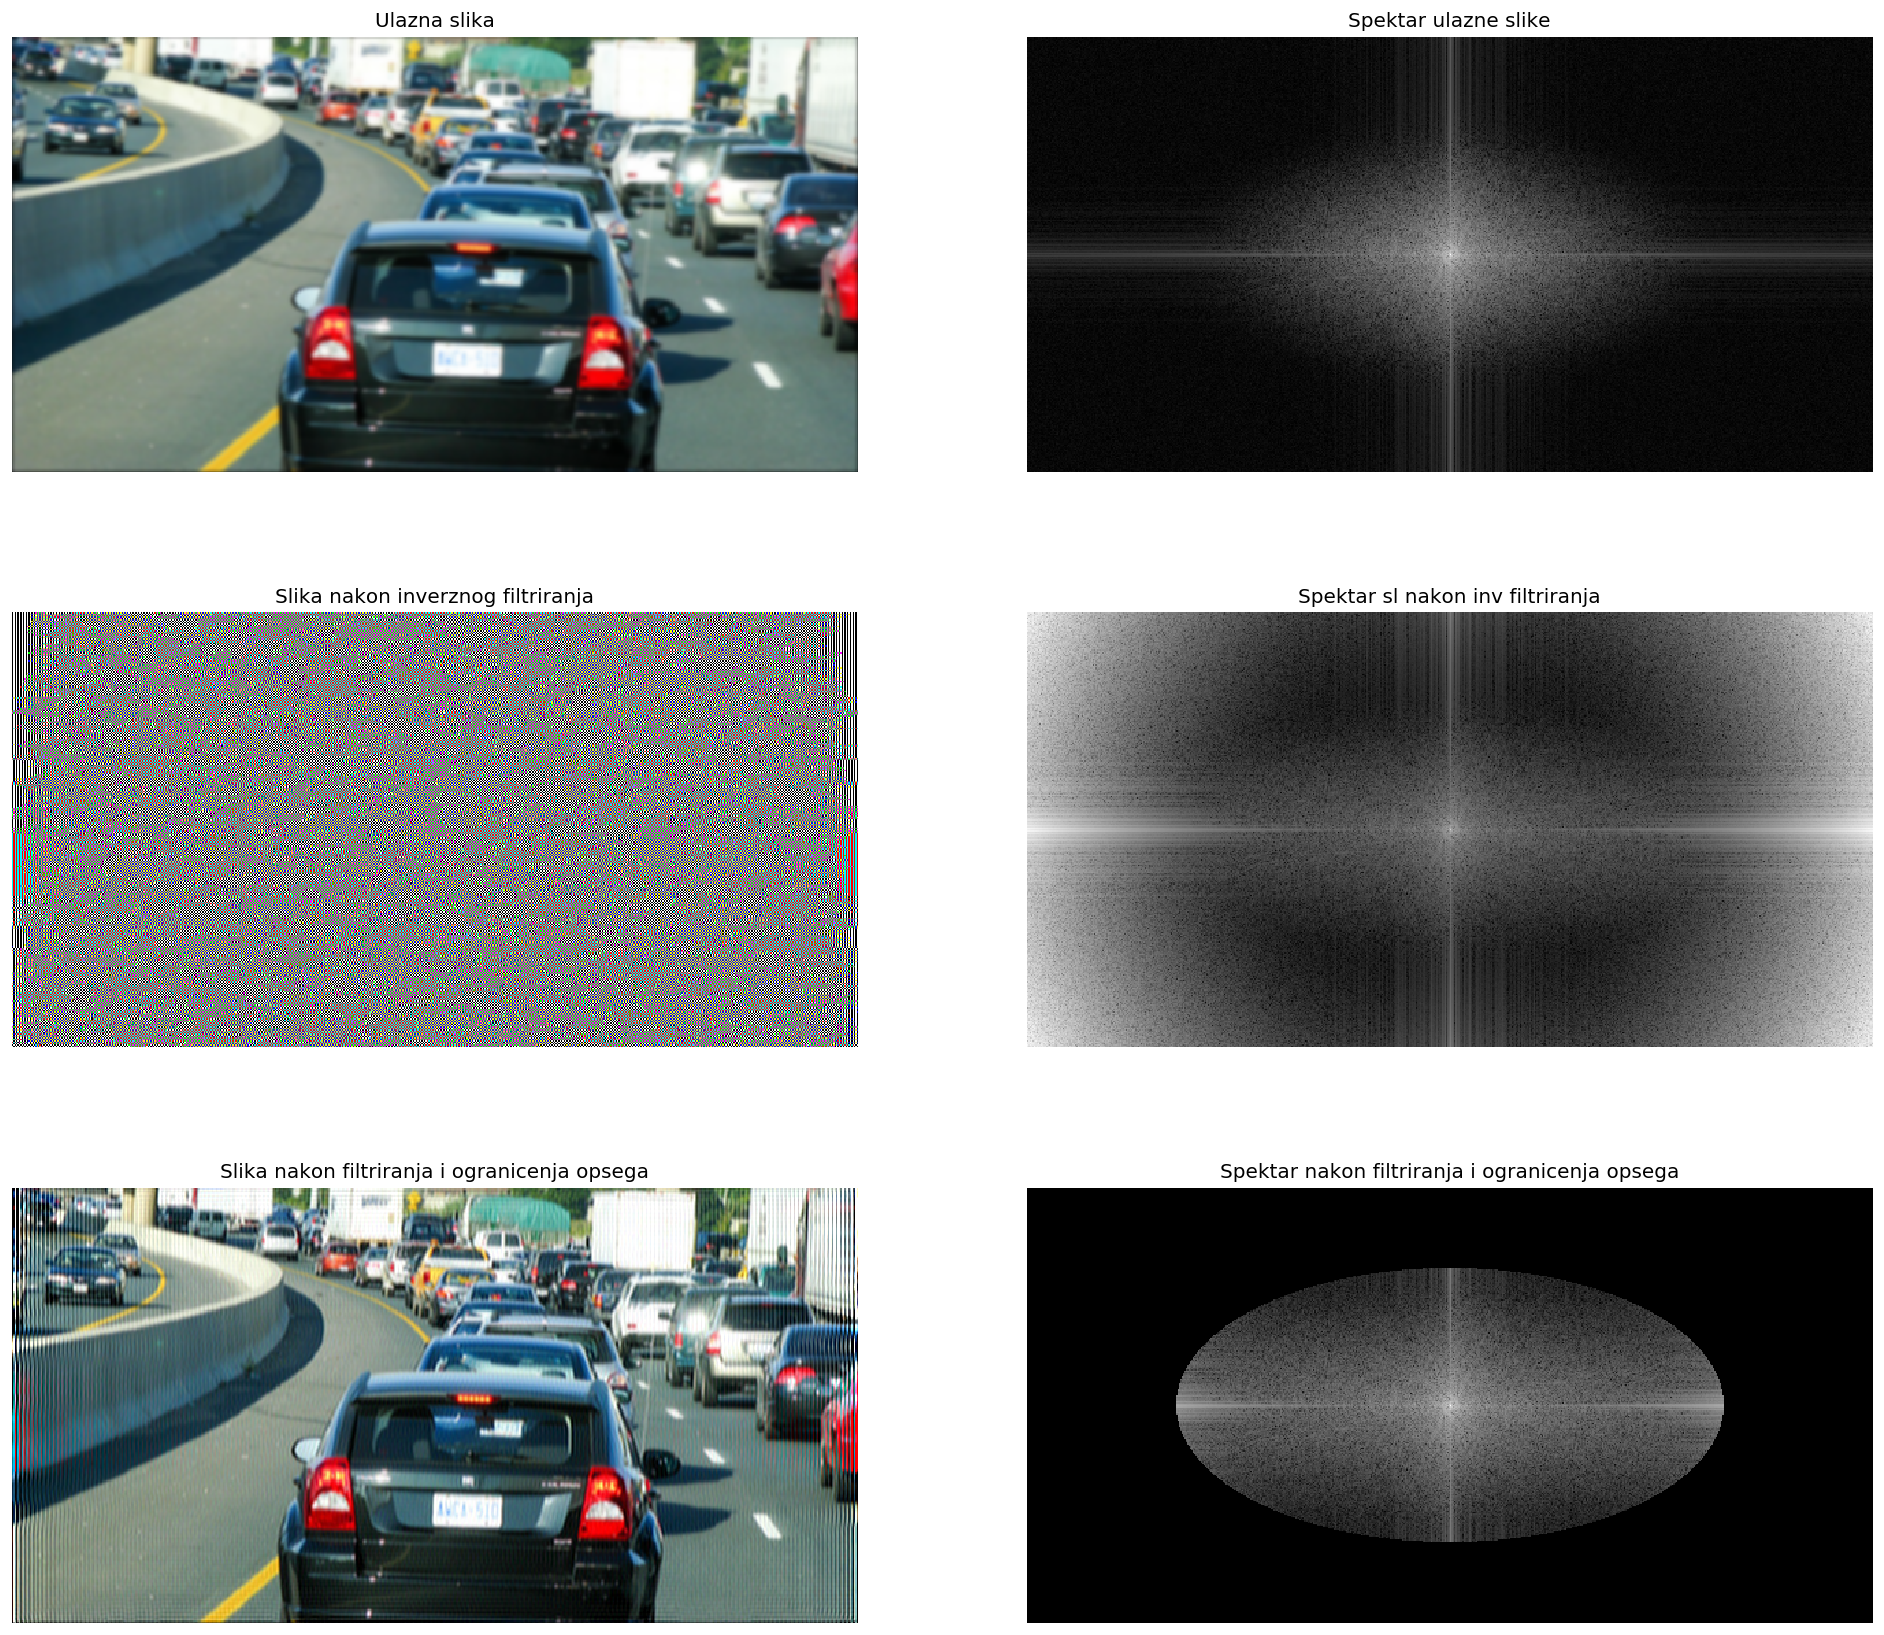

In [7]:
# ne pravimo funkciju da bismo plotovali medjurezultate

%matplotlib inline

f3 = img_as_float(imread('road_blur.png'))

# izdvajamo slojeve po bojama
f3_r = f3[:,:,0]
f3_g = f3[:,:,1]
f3_b = f3[:,:,2]

# izracuvnavamo spekte
F3_r = fftshift(fft2(f3_r))
F3_g = fftshift(fft2(f3_g))
F3_b = fftshift(fft2(f3_b))

[M,N] = shape(f3_r)
# niskopropusni filter
Hlp3 = lpfilter('ellipse',M,N,200,100) # 171, 91
# degradaciona funkcija
H_blur = lpfilter('gaussian',M,N,66)

# inverzno filtriranje po svim slojevima
F3est_r = F3_r/H_blur
F3est_g = F3_g/H_blur
F3est_b = F3_b/H_blur

# dodatno ogranicavanje opsega
F3est_filt_r = F3est_r*Hlp3 
F3est_filt_g = F3est_g*Hlp3
F3est_filt_b = F3est_b*Hlp3  

# slika nakon inverznog filtriranja
f3est = to_colored_img(F3est_r,F3est_g,F3est_b,f3)
# slika nakon dodatnog ogranicenja opsega
f3est_filter = to_colored_img(F3est_filt_r,F3est_filt_g,F3est_filt_b,f3)

fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize=(20,18), dpi=120)
ax = axes.ravel()

ax[0].imshow(f3); ax[0].set_title('Ulazna slika')
ax[1].imshow(log(1+abs(F3_g)),cmap='gray'); ax[1].set_title('Spektar ulazne slike')
ax[2].imshow(f3est); ax[2].set_title('Slika nakon inverznog filtriranja')
ax[3].imshow(log(1+abs(F3est_g)),cmap='gray'); ax[3].set_title('Spektar sl nakon inv filtriranja')
ax[4].imshow(f3est_filter); ax[4].set_title('Slika nakon filtriranja i ogranicenja opsega')
ax[5].imshow(log(1+abs(F3est_filt_g)),cmap='gray'); ax[5].set_title('Spektar nakon filtriranja i ogranicenja opsega')
ax[0].set_axis_off(); ax[1].set_axis_off(); ax[2].set_axis_off();
ax[3].set_axis_off(); ax[4].set_axis_off(); ax[5].set_axis_off();

plt.show()

### Konacna slika je prikazana ispod. Vidimo da su tablice AWCA-510.

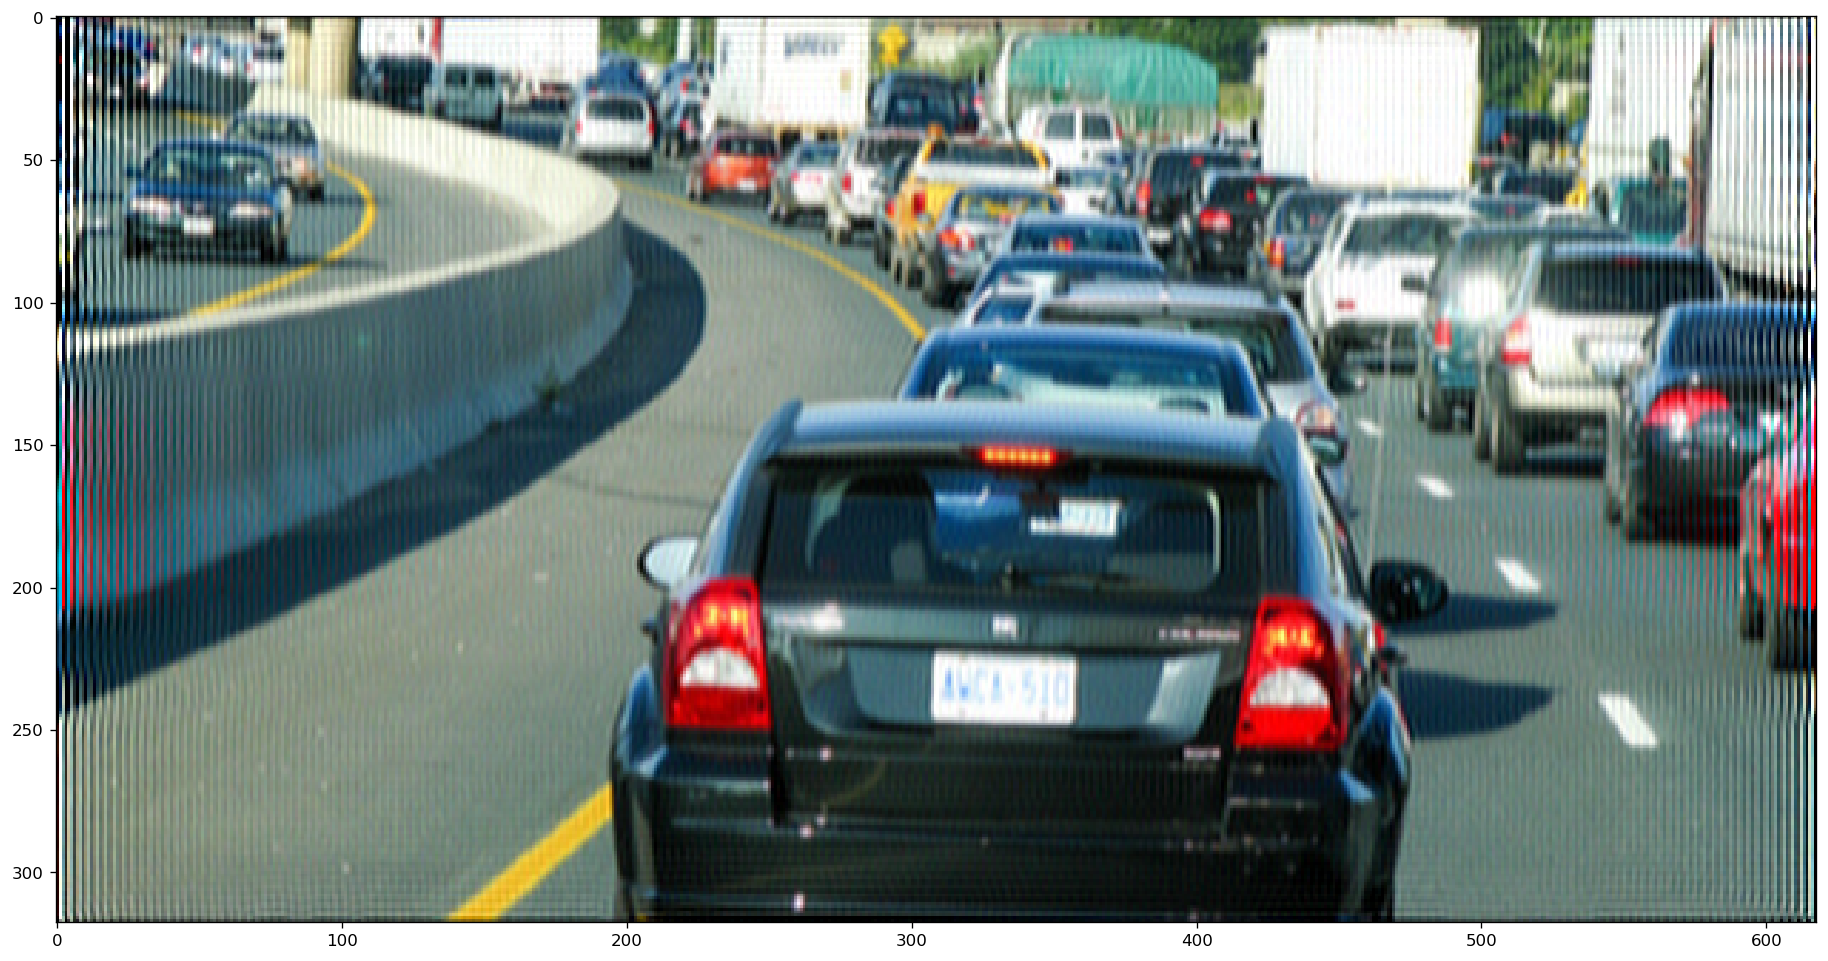

In [8]:
# zumirana konacna slika

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize=(20,10), dpi=120)
plt.imshow(f3est_filter); 




##  Cetvrti zadatak

### Potrebno je implementirati optimizovan gausov filtar u prostornom domenu i, takodje, gausov filtar u frekvencijskom domenu.  


In [5]:

def filter_gauss(f_in, radius, sigma):
    """
    filter_gaus_freq - funkcija koja filtrira ulaznu sliku
                       u prostornom domenu sa optimizacijama
    Ulazni parametri funkcije:
        f_in: ulazna slika
        radius: radijus filtra
        var: standardna devijacija filtra
    Izlaz funkcije:
        g: filtrirana slika
    """
          
    # pravljenje prosirene slike f 
    f = np.pad(f_in, ((radius, radius), (radius, radius)), 'edge')
    
    # dimenzije ulazne slike
    [M,N] = shape(f_in)
    
    # dimenzije filtra
    dim = 2*radius+1;
    x = range(-radius, radius+1)
    y = range(-radius, radius+1)
    
    # separabilnost filtra: exp((x^2+y^2)/sigma^2)=exp(x^2/sigma^2)*exp(y^2/sigma^2)
    # mozemo odvojeno primeniti funkcije po x i y osi
    X = np.matlib.repmat(x, dim, 1)
    Y = X.transpose() # zbog simetrije filtra
    
    # kreiranje maske
    mask_x = np.exp(-0.5*X**2/sigma**2)
    # normiranje
    mask_x = mask_x/sum(mask_x.flatten())
    mask_y = mask_x.transpose() # zbog simetrije filtra

    # prvo cemo da izvrsimo filtriranje po x osi
    x_conv = np.zeros([M,N+dim-1])
    for i in range(M):
        temp = np.matmul(mask_x,f[i:i+dim, :])
        x_conv[i,:] = np.sum(temp,axis = 0)
    
    # filtriranje po y osi
    # izdvajamo x_corr[:, radius:-radius] ovim samo centralne piksele, ne interesuju nas viskovi konvolcije
    x_conv_extended = np.pad(x_conv[:, radius:-radius], ((radius, radius), (radius, radius)), 'edge')
    y_conv = np.zeros([M+dim-1,N])
    for i in range(N):
        temp = np.matmul(x_conv_extended[:,i:i+dim],mask_y)
        y_conv[:,i] = np.sum(temp,axis = 1)
    out = y_conv[radius:-radius, :]
    out[out>1] = 1
    out[out<0] = 0
    return out            
                


In [6]:
def filter_gauss_freq(f, radius, sigma):
    """
    filter_gaus_freq - funkcija koja filtrira ulaznu sliku
                       u frekvencijskom domenu
    Ulazni parametri funkcije:
        f: ulazna slika
        radius: radijus filtra
        var: standardna devijacija filtra
    Izlaz funkcije:
        g: filtrirana slika
    """
    [M,N] = shape(f)

    P = 2*M-1; Q=2*N-1  
    
    # prosirivanje slike kao u ogledalu
    fp = zeros([P,Q])
    f_tr = np.transpose(f) # transponovana ulazna slika
    fp[0:M, 0:N] = f
    # zelimo da zadrzimo redosled redova, a sa [::-1] menjamo redosled redova
    fp[0:M,N-1:] = np.transpose(f_tr[::-1])  
    fp[M-1:,0:N] = f[::-1]
    fp[M-1:,N-1:] = fp[0:M,N-1:][::-1]
    
    # po tekstu zadatka
    sigma = radius/3;
    
    x = range(-radius,radius+1)
    X, Y = np.meshgrid(x,x) # Koordinate svih piksela u okviru lokalnog susedstva piksela koji se trenutno obrađuje
    
    # filter u prostornom domenu mora biti velicine ulazne slike
    filt_spatial = zeros_like(fp)
    # u centralni deo filtera na zadatom radijusu podesavamo koeficijente filtra
    filt_spatial[M-radius-1:M+radius,N-radius-1:N+radius] = np.exp(-0.5*(X**2+Y**2)/sigma**2)
    filt_spatial = filt_spatial/(sum(filt_spatial))

    Fp = fftshift(fft2(fp))     
    H = fftshift(fft2(filt_spatial))       
    Gp = H*Fp
   
    gp = real(ifft2(ifftshift(Gp)))
    g = gp[M-1:, N-1:] # u donjem levom uglu
    g[g<0] = 0
    g[g>1] = 1
    
    return g

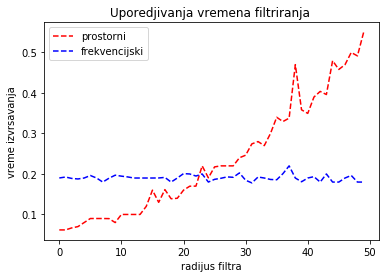

In [13]:
f = img_as_float(imread('sekvence/lena.tif'))

Np = 50;
# vektor vremena filtriranja prostornim gausovim filtrom 
time_gauss = np.zeros([Np,1])
# vektor vremena filtriranja gausovim filtrom u frekvencijskom domenu 
time_gauss_freq = np.zeros([Np,1])


for k in range(1,Np+1):
    # filtriranje u prostornom domenu 
    start = time.time()
    g_opt = filter_gauss(f,k,k/3)  
    end = time.time()
    time_gauss[k-1] = end-start;
    
    # filtriranje u frekvencijskom domenu
    start = time.time()
    g_freq = filter_gauss_freq(f,k,k/3)  
    end = time.time()
    time_gauss_freq[k-1] = end-start;
                                


plt.plot(np.arange(50), time_gauss, 'r--', label='prostorni')
plt.plot(np.arange(50), time_gauss_freq, 'b--', label='frekvencijski')

plt.xlabel('radijus filtra')
plt.ylabel('vreme izvrsavanja')
plt.title('Uporedjivanja vremena filtriranja ')
plt.legend()
plt.show()

### Mozemo sa grafika ,,Uporedjivanje vremena filtriranja" da primetimo da filtriranje u frekvencijskom domenu ima konstantno vreme izvrsavanja, dok je filtriranje u prostornom domenu linearno zavisno od radijusa filtra. Zato se za slike koje zelimo da filtriramo filtrom sa manjim radijusom preporucuje upotreba prostornog filtra, dok se kod onih sa radijusom vecih dimenzija koristi frekvencijski domen.
### Na slikama ispod mozemo videti da oba nacina filtriranja daju na oko iste rezultate, a kad prikazemo njihovu razliku, vidimo da je najveci deo slike potpuno identican, na ivicama se ponegde vidi mala razlika. 

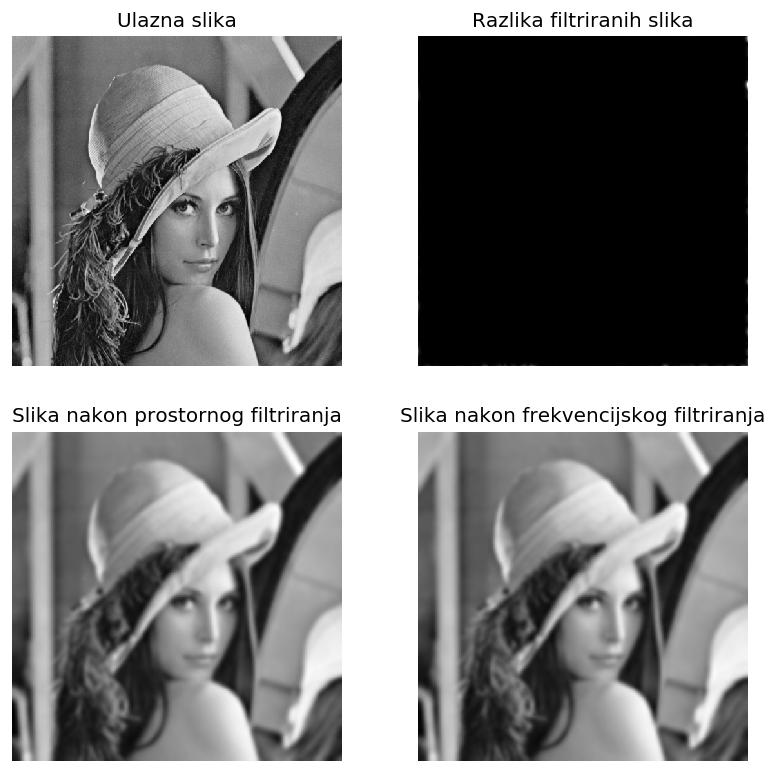

In [29]:
# demonstracija rada filtra 

k = 10
g_opt = filter_gauss(f,k,k/3)  
g_freq = filter_gauss_freq(f,k,k/3)  
error_opt_freq = abs(g_opt-g_freq)

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(8,8), dpi=120)
ax = axes.ravel()

ax[0].imshow(f,cmap='gray'); ax[0].set_title('Ulazna slika')
ax[1].imshow(error_opt_freq,cmap='gray'); ax[1].set_title('Razlika filtriranih slika')
ax[2].imshow(g_opt,cmap='gray'); ax[2].set_title('Slika nakon prostornog filtriranja')
ax[3].imshow(g_freq,cmap='gray'); ax[3].set_title('Slika nakon frekvencijskog filtriranja')
ax[0].set_axis_off(); ax[1].set_axis_off(); ax[2].set_axis_off(); ax[3].set_axis_off(); 


plt.show()